Intuition: http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
<br>Ref: https://towardsdatascience.com/learn-word2vec-by-implementing-it-in-tensorflow-45641adaf2ac

In [1]:
import numpy as np
import tensorflow as tf

### Data Preparation

Getting reading your corpus of text for training a model is a challenging job. Let's do it. NLTK packages and "re" library comes to our rescue to address this problem on larger corpus. Here we are going to see a simple text sample as an example.

In [2]:
# input corpus of text

raw_corpus = 'Asians like spicy food. Raja like spicy food.'
#raw_corpus = 'He is the king . The king is royal . She is the royal queen'
#raw_corpus = 'Well done!. Good work. Great effort. nice work. Excellent!. Weak. Poor effort!. not good. poor work. Could have done better.'

raw_corpus = raw_corpus.lower()

print(raw_corpus)

asians like spicy food. raja like spicy food.


In [3]:
# split corpus words into individual words

words = []

split_corpus = raw_corpus.split()

for word in split_corpus:
    word = word.replace(".","")
    if word != '.' and word != "":
        words.append(word)

words = set(words) # remove duplicates
        
print (words)

{'raja', 'like', 'food', 'spicy', 'asians'}


In [4]:
# convert words into integers

word2int = {}
int2word = {}

vocab_size = len(words)

for i, word in enumerate(words):
    word2int[word] = i
    int2word[i] = word

print (word2int)
print (int2word)

{'raja': 0, 'like': 1, 'food': 2, 'spicy': 3, 'asians': 4}
{0: 'raja', 1: 'like', 2: 'food', 3: 'spicy', 4: 'asians'}


In [5]:
# split words sentence wise

raw_sentence = raw_corpus.split('.')

sentences = []

for sentence in raw_sentence:
    sentences.append(sentence.split())
    
print (sentences)

[['asians', 'like', 'spicy', 'food'], ['raja', 'like', 'spicy', 'food'], []]


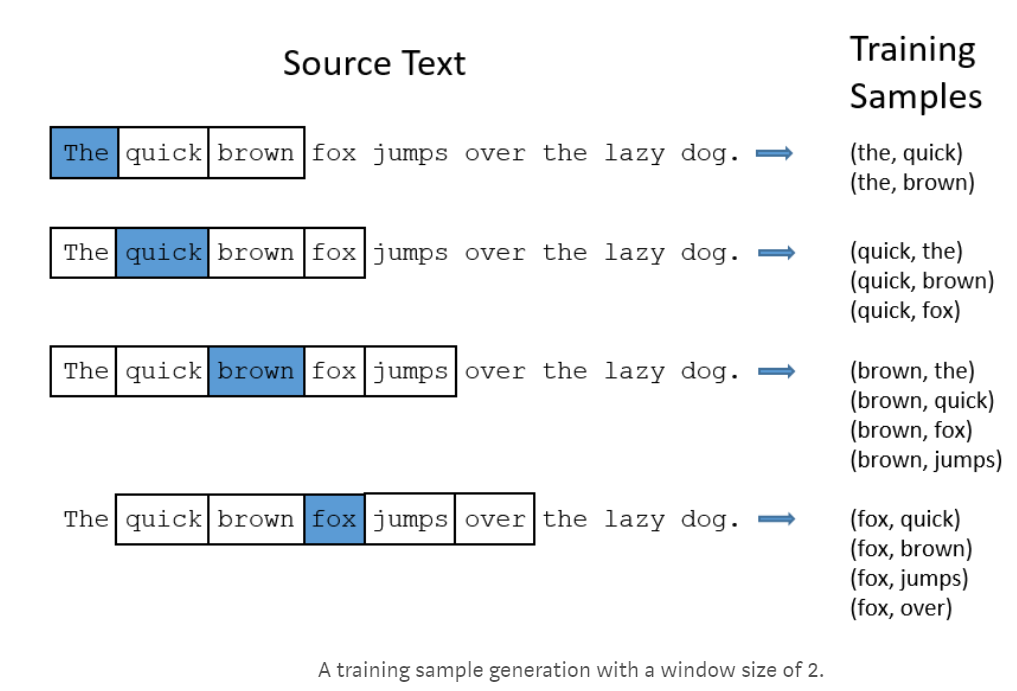

In [6]:
# generate training data with window size as 2

training_data = []
window_size = 2

for sentence in sentences:
    if len(sentence) > 0:
        for i, word in enumerate(sentence):
            idx_start = max(i - window_size, 0)
            idx_end = min(i + window_size, len(sentence)) + 1
            for nb_word in sentence[idx_start : idx_end]:
                if nb_word != word:
                    training_data.append([word, nb_word])

print(training_data)

[['asians', 'like'], ['asians', 'spicy'], ['like', 'asians'], ['like', 'spicy'], ['like', 'food'], ['spicy', 'asians'], ['spicy', 'like'], ['spicy', 'food'], ['food', 'like'], ['food', 'spicy'], ['raja', 'like'], ['raja', 'spicy'], ['like', 'raja'], ['like', 'spicy'], ['like', 'food'], ['spicy', 'raja'], ['spicy', 'like'], ['spicy', 'food'], ['food', 'like'], ['food', 'spicy']]


In [7]:
# convert the input words into one-hot notation

def convert_to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

X_train = []
y_train = []

for data_word in training_data:
    X_train.append(convert_to_one_hot(word2int[ data_word[0] ], vocab_size))
    y_train.append(convert_to_one_hot(word2int[ data_word[1] ], vocab_size))

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

print ("X_train Shape:", X_train.shape)
print (X_train)
print ("y_train Shape:", y_train.shape)
print (y_train)

X_train Shape: (20, 5)
[[ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]]
y_train Shape: (20, 5)
[[ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]]


### Prediction Model Using Tensorflow

#### Network Construction

In [8]:
# declare placeholders for X_train, y_train

X = tf.placeholder(tf.float32, shape=(None, vocab_size))
y_label = tf.placeholder(tf.float32, shape=(None, vocab_size))

In [9]:
# we require to embed the input training data into dimensions less(generally) than input

embedding_dim = 3 # assumption

# declaring variables and values for weights and bias from input to the hidden layer

w1 = tf.Variable(tf.random_normal([vocab_size, embedding_dim]))
b1 = tf.Variable(tf.random_normal([embedding_dim]))

# calculating the values that comes out from the hidden layer using matrix multiplication

hidden_representation = tf.add(tf.matmul(X, w1), b1)

In [10]:
# declaring variables and values for weights and bias from hidden layer to the output(prediction)

w2 = tf.Variable(tf.random_normal([embedding_dim, vocab_size]))
b2 = tf.Variable(tf.random_normal([vocab_size]))

prediction = tf.nn.softmax(tf.add(tf.matmul(hidden_representation, w2), b2))

#### Running NN

In [11]:
# defining session variables

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# defining loss function for evaluation

cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), reduction_indices=[1]))

# define traning algorithm and parameters

training = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy_loss)

iterations = 10000

# training for given iterations

for i in range(iterations):
    sess.run(training, feed_dict={X: X_train, y_label: y_train})
    print ('Iteration: ', i, 'Loss: ', sess.run(cross_entropy_loss, feed_dict={X: X_train, y_label: y_train}))

Iteration:  0 Loss:  2.37387
Iteration:  1 Loss:  2.24818
Iteration:  2 Loss:  2.13848
Iteration:  3 Loss:  2.04399
Iteration:  4 Loss:  1.96338
Iteration:  5 Loss:  1.89494
Iteration:  6 Loss:  1.83674
Iteration:  7 Loss:  1.78686
Iteration:  8 Loss:  1.7436
Iteration:  9 Loss:  1.70555
Iteration:  10 Loss:  1.67164
Iteration:  11 Loss:  1.64106
Iteration:  12 Loss:  1.61321
Iteration:  13 Loss:  1.58767
Iteration:  14 Loss:  1.56413
Iteration:  15 Loss:  1.54232
Iteration:  16 Loss:  1.52206
Iteration:  17 Loss:  1.5032
Iteration:  18 Loss:  1.48559
Iteration:  19 Loss:  1.46912
Iteration:  20 Loss:  1.4537
Iteration:  21 Loss:  1.43922
Iteration:  22 Loss:  1.42563
Iteration:  23 Loss:  1.41284
Iteration:  24 Loss:  1.40079
Iteration:  25 Loss:  1.38943
Iteration:  26 Loss:  1.3787
Iteration:  27 Loss:  1.36855
Iteration:  28 Loss:  1.35895
Iteration:  29 Loss:  1.34986
Iteration:  30 Loss:  1.34123
Iteration:  31 Loss:  1.33304
Iteration:  32 Loss:  1.32526
Iteration:  33 Loss:  1.

Iteration:  315 Loss:  1.09056
Iteration:  316 Loss:  1.09049
Iteration:  317 Loss:  1.09042
Iteration:  318 Loss:  1.09036
Iteration:  319 Loss:  1.09029
Iteration:  320 Loss:  1.09023
Iteration:  321 Loss:  1.09016
Iteration:  322 Loss:  1.0901
Iteration:  323 Loss:  1.09003
Iteration:  324 Loss:  1.08997
Iteration:  325 Loss:  1.08991
Iteration:  326 Loss:  1.08985
Iteration:  327 Loss:  1.08978
Iteration:  328 Loss:  1.08972
Iteration:  329 Loss:  1.08966
Iteration:  330 Loss:  1.0896
Iteration:  331 Loss:  1.08954
Iteration:  332 Loss:  1.08948
Iteration:  333 Loss:  1.08942
Iteration:  334 Loss:  1.08936
Iteration:  335 Loss:  1.0893
Iteration:  336 Loss:  1.08925
Iteration:  337 Loss:  1.08919
Iteration:  338 Loss:  1.08913
Iteration:  339 Loss:  1.08907
Iteration:  340 Loss:  1.08902
Iteration:  341 Loss:  1.08896
Iteration:  342 Loss:  1.0889
Iteration:  343 Loss:  1.08885
Iteration:  344 Loss:  1.08879
Iteration:  345 Loss:  1.08874
Iteration:  346 Loss:  1.08869
Iteration:  

Iteration:  621 Loss:  1.08118
Iteration:  622 Loss:  1.08117
Iteration:  623 Loss:  1.08115
Iteration:  624 Loss:  1.08114
Iteration:  625 Loss:  1.08113
Iteration:  626 Loss:  1.08111
Iteration:  627 Loss:  1.0811
Iteration:  628 Loss:  1.08109
Iteration:  629 Loss:  1.08107
Iteration:  630 Loss:  1.08106
Iteration:  631 Loss:  1.08105
Iteration:  632 Loss:  1.08104
Iteration:  633 Loss:  1.08102
Iteration:  634 Loss:  1.08101
Iteration:  635 Loss:  1.081
Iteration:  636 Loss:  1.08098
Iteration:  637 Loss:  1.08097
Iteration:  638 Loss:  1.08096
Iteration:  639 Loss:  1.08095
Iteration:  640 Loss:  1.08093
Iteration:  641 Loss:  1.08092
Iteration:  642 Loss:  1.08091
Iteration:  643 Loss:  1.0809
Iteration:  644 Loss:  1.08089
Iteration:  645 Loss:  1.08087
Iteration:  646 Loss:  1.08086
Iteration:  647 Loss:  1.08085
Iteration:  648 Loss:  1.08084
Iteration:  649 Loss:  1.08083
Iteration:  650 Loss:  1.08081
Iteration:  651 Loss:  1.0808
Iteration:  652 Loss:  1.08079
Iteration:  6

Iteration:  927 Loss:  1.07865
Iteration:  928 Loss:  1.07864
Iteration:  929 Loss:  1.07864
Iteration:  930 Loss:  1.07863
Iteration:  931 Loss:  1.07863
Iteration:  932 Loss:  1.07862
Iteration:  933 Loss:  1.07862
Iteration:  934 Loss:  1.07861
Iteration:  935 Loss:  1.07861
Iteration:  936 Loss:  1.0786
Iteration:  937 Loss:  1.0786
Iteration:  938 Loss:  1.07859
Iteration:  939 Loss:  1.07859
Iteration:  940 Loss:  1.07858
Iteration:  941 Loss:  1.07858
Iteration:  942 Loss:  1.07857
Iteration:  943 Loss:  1.07857
Iteration:  944 Loss:  1.07856
Iteration:  945 Loss:  1.07856
Iteration:  946 Loss:  1.07855
Iteration:  947 Loss:  1.07855
Iteration:  948 Loss:  1.07854
Iteration:  949 Loss:  1.07854
Iteration:  950 Loss:  1.07853
Iteration:  951 Loss:  1.07853
Iteration:  952 Loss:  1.07853
Iteration:  953 Loss:  1.07852
Iteration:  954 Loss:  1.07852
Iteration:  955 Loss:  1.07851
Iteration:  956 Loss:  1.07851
Iteration:  957 Loss:  1.0785
Iteration:  958 Loss:  1.0785
Iteration:  

Iteration:  1232 Loss:  1.07754
Iteration:  1233 Loss:  1.07754
Iteration:  1234 Loss:  1.07753
Iteration:  1235 Loss:  1.07753
Iteration:  1236 Loss:  1.07753
Iteration:  1237 Loss:  1.07753
Iteration:  1238 Loss:  1.07752
Iteration:  1239 Loss:  1.07752
Iteration:  1240 Loss:  1.07752
Iteration:  1241 Loss:  1.07752
Iteration:  1242 Loss:  1.07751
Iteration:  1243 Loss:  1.07751
Iteration:  1244 Loss:  1.07751
Iteration:  1245 Loss:  1.07751
Iteration:  1246 Loss:  1.0775
Iteration:  1247 Loss:  1.0775
Iteration:  1248 Loss:  1.0775
Iteration:  1249 Loss:  1.0775
Iteration:  1250 Loss:  1.07749
Iteration:  1251 Loss:  1.07749
Iteration:  1252 Loss:  1.07749
Iteration:  1253 Loss:  1.07749
Iteration:  1254 Loss:  1.07748
Iteration:  1255 Loss:  1.07748
Iteration:  1256 Loss:  1.07748
Iteration:  1257 Loss:  1.07748
Iteration:  1258 Loss:  1.07747
Iteration:  1259 Loss:  1.07747
Iteration:  1260 Loss:  1.07747
Iteration:  1261 Loss:  1.07747
Iteration:  1262 Loss:  1.07746
Iteration:  

Iteration:  1539 Loss:  1.07693
Iteration:  1540 Loss:  1.07692
Iteration:  1541 Loss:  1.07692
Iteration:  1542 Loss:  1.07692
Iteration:  1543 Loss:  1.07692
Iteration:  1544 Loss:  1.07692
Iteration:  1545 Loss:  1.07692
Iteration:  1546 Loss:  1.07691
Iteration:  1547 Loss:  1.07691
Iteration:  1548 Loss:  1.07691
Iteration:  1549 Loss:  1.07691
Iteration:  1550 Loss:  1.07691
Iteration:  1551 Loss:  1.07691
Iteration:  1552 Loss:  1.07691
Iteration:  1553 Loss:  1.0769
Iteration:  1554 Loss:  1.0769
Iteration:  1555 Loss:  1.0769
Iteration:  1556 Loss:  1.0769
Iteration:  1557 Loss:  1.0769
Iteration:  1558 Loss:  1.0769
Iteration:  1559 Loss:  1.07689
Iteration:  1560 Loss:  1.07689
Iteration:  1561 Loss:  1.07689
Iteration:  1562 Loss:  1.07689
Iteration:  1563 Loss:  1.07689
Iteration:  1564 Loss:  1.07689
Iteration:  1565 Loss:  1.07689
Iteration:  1566 Loss:  1.07688
Iteration:  1567 Loss:  1.07688
Iteration:  1568 Loss:  1.07688
Iteration:  1569 Loss:  1.07688
Iteration:  15

Iteration:  1849 Loss:  1.07654
Iteration:  1850 Loss:  1.07654
Iteration:  1851 Loss:  1.07654
Iteration:  1852 Loss:  1.07654
Iteration:  1853 Loss:  1.07654
Iteration:  1854 Loss:  1.07653
Iteration:  1855 Loss:  1.07653
Iteration:  1856 Loss:  1.07653
Iteration:  1857 Loss:  1.07653
Iteration:  1858 Loss:  1.07653
Iteration:  1859 Loss:  1.07653
Iteration:  1860 Loss:  1.07653
Iteration:  1861 Loss:  1.07653
Iteration:  1862 Loss:  1.07653
Iteration:  1863 Loss:  1.07653
Iteration:  1864 Loss:  1.07652
Iteration:  1865 Loss:  1.07652
Iteration:  1866 Loss:  1.07652
Iteration:  1867 Loss:  1.07652
Iteration:  1868 Loss:  1.07652
Iteration:  1869 Loss:  1.07652
Iteration:  1870 Loss:  1.07652
Iteration:  1871 Loss:  1.07652
Iteration:  1872 Loss:  1.07652
Iteration:  1873 Loss:  1.07652
Iteration:  1874 Loss:  1.07651
Iteration:  1875 Loss:  1.07651
Iteration:  1876 Loss:  1.07651
Iteration:  1877 Loss:  1.07651
Iteration:  1878 Loss:  1.07651
Iteration:  1879 Loss:  1.07651
Iteratio

Iteration:  2160 Loss:  1.07628
Iteration:  2161 Loss:  1.07628
Iteration:  2162 Loss:  1.07628
Iteration:  2163 Loss:  1.07628
Iteration:  2164 Loss:  1.07628
Iteration:  2165 Loss:  1.07627
Iteration:  2166 Loss:  1.07627
Iteration:  2167 Loss:  1.07627
Iteration:  2168 Loss:  1.07627
Iteration:  2169 Loss:  1.07627
Iteration:  2170 Loss:  1.07627
Iteration:  2171 Loss:  1.07627
Iteration:  2172 Loss:  1.07627
Iteration:  2173 Loss:  1.07627
Iteration:  2174 Loss:  1.07627
Iteration:  2175 Loss:  1.07627
Iteration:  2176 Loss:  1.07627
Iteration:  2177 Loss:  1.07627
Iteration:  2178 Loss:  1.07627
Iteration:  2179 Loss:  1.07627
Iteration:  2180 Loss:  1.07626
Iteration:  2181 Loss:  1.07626
Iteration:  2182 Loss:  1.07626
Iteration:  2183 Loss:  1.07626
Iteration:  2184 Loss:  1.07626
Iteration:  2185 Loss:  1.07626
Iteration:  2186 Loss:  1.07626
Iteration:  2187 Loss:  1.07626
Iteration:  2188 Loss:  1.07626
Iteration:  2189 Loss:  1.07626
Iteration:  2190 Loss:  1.07626
Iteratio

Iteration:  2463 Loss:  1.0761
Iteration:  2464 Loss:  1.07609
Iteration:  2465 Loss:  1.07609
Iteration:  2466 Loss:  1.07609
Iteration:  2467 Loss:  1.07609
Iteration:  2468 Loss:  1.07609
Iteration:  2469 Loss:  1.07609
Iteration:  2470 Loss:  1.07609
Iteration:  2471 Loss:  1.07609
Iteration:  2472 Loss:  1.07609
Iteration:  2473 Loss:  1.07609
Iteration:  2474 Loss:  1.07609
Iteration:  2475 Loss:  1.07609
Iteration:  2476 Loss:  1.07609
Iteration:  2477 Loss:  1.07609
Iteration:  2478 Loss:  1.07609
Iteration:  2479 Loss:  1.07609
Iteration:  2480 Loss:  1.07609
Iteration:  2481 Loss:  1.07609
Iteration:  2482 Loss:  1.07609
Iteration:  2483 Loss:  1.07609
Iteration:  2484 Loss:  1.07608
Iteration:  2485 Loss:  1.07608
Iteration:  2486 Loss:  1.07608
Iteration:  2487 Loss:  1.07608
Iteration:  2488 Loss:  1.07608
Iteration:  2489 Loss:  1.07608
Iteration:  2490 Loss:  1.07608
Iteration:  2491 Loss:  1.07608
Iteration:  2492 Loss:  1.07608
Iteration:  2493 Loss:  1.07608
Iteration

Iteration:  2769 Loss:  1.07596
Iteration:  2770 Loss:  1.07596
Iteration:  2771 Loss:  1.07596
Iteration:  2772 Loss:  1.07596
Iteration:  2773 Loss:  1.07595
Iteration:  2774 Loss:  1.07595
Iteration:  2775 Loss:  1.07595
Iteration:  2776 Loss:  1.07595
Iteration:  2777 Loss:  1.07595
Iteration:  2778 Loss:  1.07595
Iteration:  2779 Loss:  1.07595
Iteration:  2780 Loss:  1.07595
Iteration:  2781 Loss:  1.07595
Iteration:  2782 Loss:  1.07595
Iteration:  2783 Loss:  1.07595
Iteration:  2784 Loss:  1.07595
Iteration:  2785 Loss:  1.07595
Iteration:  2786 Loss:  1.07595
Iteration:  2787 Loss:  1.07595
Iteration:  2788 Loss:  1.07595
Iteration:  2789 Loss:  1.07595
Iteration:  2790 Loss:  1.07595
Iteration:  2791 Loss:  1.07595
Iteration:  2792 Loss:  1.07595
Iteration:  2793 Loss:  1.07595
Iteration:  2794 Loss:  1.07595
Iteration:  2795 Loss:  1.07595
Iteration:  2796 Loss:  1.07595
Iteration:  2797 Loss:  1.07595
Iteration:  2798 Loss:  1.07594
Iteration:  2799 Loss:  1.07594
Iteratio

Iteration:  3050 Loss:  1.07586
Iteration:  3051 Loss:  1.07586
Iteration:  3052 Loss:  1.07586
Iteration:  3053 Loss:  1.07586
Iteration:  3054 Loss:  1.07585
Iteration:  3055 Loss:  1.07585
Iteration:  3056 Loss:  1.07585
Iteration:  3057 Loss:  1.07585
Iteration:  3058 Loss:  1.07585
Iteration:  3059 Loss:  1.07585
Iteration:  3060 Loss:  1.07585
Iteration:  3061 Loss:  1.07585
Iteration:  3062 Loss:  1.07585
Iteration:  3063 Loss:  1.07585
Iteration:  3064 Loss:  1.07585
Iteration:  3065 Loss:  1.07585
Iteration:  3066 Loss:  1.07585
Iteration:  3067 Loss:  1.07585
Iteration:  3068 Loss:  1.07585
Iteration:  3069 Loss:  1.07585
Iteration:  3070 Loss:  1.07585
Iteration:  3071 Loss:  1.07585
Iteration:  3072 Loss:  1.07585
Iteration:  3073 Loss:  1.07585
Iteration:  3074 Loss:  1.07585
Iteration:  3075 Loss:  1.07585
Iteration:  3076 Loss:  1.07585
Iteration:  3077 Loss:  1.07585
Iteration:  3078 Loss:  1.07585
Iteration:  3079 Loss:  1.07585
Iteration:  3080 Loss:  1.07585
Iteratio

Iteration:  3349 Loss:  1.07577
Iteration:  3350 Loss:  1.07577
Iteration:  3351 Loss:  1.07577
Iteration:  3352 Loss:  1.07577
Iteration:  3353 Loss:  1.07577
Iteration:  3354 Loss:  1.07577
Iteration:  3355 Loss:  1.07577
Iteration:  3356 Loss:  1.07577
Iteration:  3357 Loss:  1.07577
Iteration:  3358 Loss:  1.07577
Iteration:  3359 Loss:  1.07577
Iteration:  3360 Loss:  1.07577
Iteration:  3361 Loss:  1.07577
Iteration:  3362 Loss:  1.07577
Iteration:  3363 Loss:  1.07577
Iteration:  3364 Loss:  1.07577
Iteration:  3365 Loss:  1.07577
Iteration:  3366 Loss:  1.07577
Iteration:  3367 Loss:  1.07577
Iteration:  3368 Loss:  1.07577
Iteration:  3369 Loss:  1.07576
Iteration:  3370 Loss:  1.07576
Iteration:  3371 Loss:  1.07576
Iteration:  3372 Loss:  1.07576
Iteration:  3373 Loss:  1.07576
Iteration:  3374 Loss:  1.07576
Iteration:  3375 Loss:  1.07576
Iteration:  3376 Loss:  1.07576
Iteration:  3377 Loss:  1.07576
Iteration:  3378 Loss:  1.07576
Iteration:  3379 Loss:  1.07576
Iteratio

Iteration:  3635 Loss:  1.0757
Iteration:  3636 Loss:  1.0757
Iteration:  3637 Loss:  1.0757
Iteration:  3638 Loss:  1.0757
Iteration:  3639 Loss:  1.0757
Iteration:  3640 Loss:  1.0757
Iteration:  3641 Loss:  1.0757
Iteration:  3642 Loss:  1.0757
Iteration:  3643 Loss:  1.0757
Iteration:  3644 Loss:  1.0757
Iteration:  3645 Loss:  1.0757
Iteration:  3646 Loss:  1.0757
Iteration:  3647 Loss:  1.0757
Iteration:  3648 Loss:  1.0757
Iteration:  3649 Loss:  1.0757
Iteration:  3650 Loss:  1.0757
Iteration:  3651 Loss:  1.0757
Iteration:  3652 Loss:  1.0757
Iteration:  3653 Loss:  1.0757
Iteration:  3654 Loss:  1.0757
Iteration:  3655 Loss:  1.0757
Iteration:  3656 Loss:  1.0757
Iteration:  3657 Loss:  1.0757
Iteration:  3658 Loss:  1.0757
Iteration:  3659 Loss:  1.0757
Iteration:  3660 Loss:  1.0757
Iteration:  3661 Loss:  1.0757
Iteration:  3662 Loss:  1.0757
Iteration:  3663 Loss:  1.0757
Iteration:  3664 Loss:  1.0757
Iteration:  3665 Loss:  1.0757
Iteration:  3666 Loss:  1.0757
Iteratio

Iteration:  3918 Loss:  1.07565
Iteration:  3919 Loss:  1.07565
Iteration:  3920 Loss:  1.07565
Iteration:  3921 Loss:  1.07565
Iteration:  3922 Loss:  1.07565
Iteration:  3923 Loss:  1.07565
Iteration:  3924 Loss:  1.07565
Iteration:  3925 Loss:  1.07565
Iteration:  3926 Loss:  1.07565
Iteration:  3927 Loss:  1.07565
Iteration:  3928 Loss:  1.07564
Iteration:  3929 Loss:  1.07564
Iteration:  3930 Loss:  1.07564
Iteration:  3931 Loss:  1.07564
Iteration:  3932 Loss:  1.07564
Iteration:  3933 Loss:  1.07564
Iteration:  3934 Loss:  1.07564
Iteration:  3935 Loss:  1.07564
Iteration:  3936 Loss:  1.07564
Iteration:  3937 Loss:  1.07564
Iteration:  3938 Loss:  1.07564
Iteration:  3939 Loss:  1.07564
Iteration:  3940 Loss:  1.07564
Iteration:  3941 Loss:  1.07564
Iteration:  3942 Loss:  1.07564
Iteration:  3943 Loss:  1.07564
Iteration:  3944 Loss:  1.07564
Iteration:  3945 Loss:  1.07564
Iteration:  3946 Loss:  1.07564
Iteration:  3947 Loss:  1.07564
Iteration:  3948 Loss:  1.07564
Iteratio

Iteration:  4213 Loss:  1.0756
Iteration:  4214 Loss:  1.0756
Iteration:  4215 Loss:  1.0756
Iteration:  4216 Loss:  1.0756
Iteration:  4217 Loss:  1.0756
Iteration:  4218 Loss:  1.0756
Iteration:  4219 Loss:  1.0756
Iteration:  4220 Loss:  1.0756
Iteration:  4221 Loss:  1.0756
Iteration:  4222 Loss:  1.0756
Iteration:  4223 Loss:  1.0756
Iteration:  4224 Loss:  1.0756
Iteration:  4225 Loss:  1.0756
Iteration:  4226 Loss:  1.0756
Iteration:  4227 Loss:  1.0756
Iteration:  4228 Loss:  1.0756
Iteration:  4229 Loss:  1.0756
Iteration:  4230 Loss:  1.07559
Iteration:  4231 Loss:  1.07559
Iteration:  4232 Loss:  1.07559
Iteration:  4233 Loss:  1.07559
Iteration:  4234 Loss:  1.07559
Iteration:  4235 Loss:  1.07559
Iteration:  4236 Loss:  1.07559
Iteration:  4237 Loss:  1.07559
Iteration:  4238 Loss:  1.07559
Iteration:  4239 Loss:  1.07559
Iteration:  4240 Loss:  1.07559
Iteration:  4241 Loss:  1.07559
Iteration:  4242 Loss:  1.07559
Iteration:  4243 Loss:  1.07559
Iteration:  4244 Loss:  1

Iteration:  4516 Loss:  1.07555
Iteration:  4517 Loss:  1.07555
Iteration:  4518 Loss:  1.07555
Iteration:  4519 Loss:  1.07555
Iteration:  4520 Loss:  1.07555
Iteration:  4521 Loss:  1.07555
Iteration:  4522 Loss:  1.07555
Iteration:  4523 Loss:  1.07555
Iteration:  4524 Loss:  1.07555
Iteration:  4525 Loss:  1.07555
Iteration:  4526 Loss:  1.07555
Iteration:  4527 Loss:  1.07555
Iteration:  4528 Loss:  1.07555
Iteration:  4529 Loss:  1.07555
Iteration:  4530 Loss:  1.07555
Iteration:  4531 Loss:  1.07555
Iteration:  4532 Loss:  1.07555
Iteration:  4533 Loss:  1.07555
Iteration:  4534 Loss:  1.07555
Iteration:  4535 Loss:  1.07555
Iteration:  4536 Loss:  1.07555
Iteration:  4537 Loss:  1.07555
Iteration:  4538 Loss:  1.07555
Iteration:  4539 Loss:  1.07555
Iteration:  4540 Loss:  1.07555
Iteration:  4541 Loss:  1.07555
Iteration:  4542 Loss:  1.07555
Iteration:  4543 Loss:  1.07555
Iteration:  4544 Loss:  1.07555
Iteration:  4545 Loss:  1.07555
Iteration:  4546 Loss:  1.07555
Iteratio

Iteration:  4816 Loss:  1.07552
Iteration:  4817 Loss:  1.07552
Iteration:  4818 Loss:  1.07552
Iteration:  4819 Loss:  1.07552
Iteration:  4820 Loss:  1.07552
Iteration:  4821 Loss:  1.07552
Iteration:  4822 Loss:  1.07552
Iteration:  4823 Loss:  1.07552
Iteration:  4824 Loss:  1.07552
Iteration:  4825 Loss:  1.07552
Iteration:  4826 Loss:  1.07552
Iteration:  4827 Loss:  1.07552
Iteration:  4828 Loss:  1.07552
Iteration:  4829 Loss:  1.07552
Iteration:  4830 Loss:  1.07552
Iteration:  4831 Loss:  1.07552
Iteration:  4832 Loss:  1.07552
Iteration:  4833 Loss:  1.07552
Iteration:  4834 Loss:  1.07552
Iteration:  4835 Loss:  1.07552
Iteration:  4836 Loss:  1.07552
Iteration:  4837 Loss:  1.07552
Iteration:  4838 Loss:  1.07551
Iteration:  4839 Loss:  1.07551
Iteration:  4840 Loss:  1.07551
Iteration:  4841 Loss:  1.07551
Iteration:  4842 Loss:  1.07551
Iteration:  4843 Loss:  1.07551
Iteration:  4844 Loss:  1.07551
Iteration:  4845 Loss:  1.07551
Iteration:  4846 Loss:  1.07551
Iteratio

Iteration:  5101 Loss:  1.07549
Iteration:  5102 Loss:  1.07549
Iteration:  5103 Loss:  1.07549
Iteration:  5104 Loss:  1.07549
Iteration:  5105 Loss:  1.07549
Iteration:  5106 Loss:  1.07549
Iteration:  5107 Loss:  1.07549
Iteration:  5108 Loss:  1.07549
Iteration:  5109 Loss:  1.07549
Iteration:  5110 Loss:  1.07549
Iteration:  5111 Loss:  1.07549
Iteration:  5112 Loss:  1.07549
Iteration:  5113 Loss:  1.07549
Iteration:  5114 Loss:  1.07549
Iteration:  5115 Loss:  1.07549
Iteration:  5116 Loss:  1.07549
Iteration:  5117 Loss:  1.07549
Iteration:  5118 Loss:  1.07548
Iteration:  5119 Loss:  1.07548
Iteration:  5120 Loss:  1.07548
Iteration:  5121 Loss:  1.07548
Iteration:  5122 Loss:  1.07548
Iteration:  5123 Loss:  1.07548
Iteration:  5124 Loss:  1.07548
Iteration:  5125 Loss:  1.07548
Iteration:  5126 Loss:  1.07548
Iteration:  5127 Loss:  1.07548
Iteration:  5128 Loss:  1.07548
Iteration:  5129 Loss:  1.07548
Iteration:  5130 Loss:  1.07548
Iteration:  5131 Loss:  1.07548
Iteratio

Iteration:  5400 Loss:  1.07546
Iteration:  5401 Loss:  1.07546
Iteration:  5402 Loss:  1.07546
Iteration:  5403 Loss:  1.07546
Iteration:  5404 Loss:  1.07546
Iteration:  5405 Loss:  1.07546
Iteration:  5406 Loss:  1.07546
Iteration:  5407 Loss:  1.07546
Iteration:  5408 Loss:  1.07546
Iteration:  5409 Loss:  1.07546
Iteration:  5410 Loss:  1.07546
Iteration:  5411 Loss:  1.07546
Iteration:  5412 Loss:  1.07546
Iteration:  5413 Loss:  1.07546
Iteration:  5414 Loss:  1.07546
Iteration:  5415 Loss:  1.07546
Iteration:  5416 Loss:  1.07546
Iteration:  5417 Loss:  1.07546
Iteration:  5418 Loss:  1.07546
Iteration:  5419 Loss:  1.07546
Iteration:  5420 Loss:  1.07546
Iteration:  5421 Loss:  1.07546
Iteration:  5422 Loss:  1.07546
Iteration:  5423 Loss:  1.07546
Iteration:  5424 Loss:  1.07546
Iteration:  5425 Loss:  1.07546
Iteration:  5426 Loss:  1.07546
Iteration:  5427 Loss:  1.07546
Iteration:  5428 Loss:  1.07546
Iteration:  5429 Loss:  1.07546
Iteration:  5430 Loss:  1.07546
Iteratio

Iteration:  5705 Loss:  1.07543
Iteration:  5706 Loss:  1.07543
Iteration:  5707 Loss:  1.07543
Iteration:  5708 Loss:  1.07543
Iteration:  5709 Loss:  1.07543
Iteration:  5710 Loss:  1.07543
Iteration:  5711 Loss:  1.07543
Iteration:  5712 Loss:  1.07543
Iteration:  5713 Loss:  1.07543
Iteration:  5714 Loss:  1.07543
Iteration:  5715 Loss:  1.07543
Iteration:  5716 Loss:  1.07543
Iteration:  5717 Loss:  1.07543
Iteration:  5718 Loss:  1.07543
Iteration:  5719 Loss:  1.07543
Iteration:  5720 Loss:  1.07543
Iteration:  5721 Loss:  1.07543
Iteration:  5722 Loss:  1.07543
Iteration:  5723 Loss:  1.07543
Iteration:  5724 Loss:  1.07543
Iteration:  5725 Loss:  1.07543
Iteration:  5726 Loss:  1.07543
Iteration:  5727 Loss:  1.07543
Iteration:  5728 Loss:  1.07543
Iteration:  5729 Loss:  1.07543
Iteration:  5730 Loss:  1.07543
Iteration:  5731 Loss:  1.07543
Iteration:  5732 Loss:  1.07543
Iteration:  5733 Loss:  1.07543
Iteration:  5734 Loss:  1.07543
Iteration:  5735 Loss:  1.07543
Iteratio

Iteration:  6005 Loss:  1.07541
Iteration:  6006 Loss:  1.07541
Iteration:  6007 Loss:  1.07541
Iteration:  6008 Loss:  1.07541
Iteration:  6009 Loss:  1.07541
Iteration:  6010 Loss:  1.07541
Iteration:  6011 Loss:  1.07541
Iteration:  6012 Loss:  1.07541
Iteration:  6013 Loss:  1.07541
Iteration:  6014 Loss:  1.07541
Iteration:  6015 Loss:  1.07541
Iteration:  6016 Loss:  1.07541
Iteration:  6017 Loss:  1.07541
Iteration:  6018 Loss:  1.07541
Iteration:  6019 Loss:  1.07541
Iteration:  6020 Loss:  1.07541
Iteration:  6021 Loss:  1.07541
Iteration:  6022 Loss:  1.07541
Iteration:  6023 Loss:  1.07541
Iteration:  6024 Loss:  1.07541
Iteration:  6025 Loss:  1.07541
Iteration:  6026 Loss:  1.07541
Iteration:  6027 Loss:  1.07541
Iteration:  6028 Loss:  1.07541
Iteration:  6029 Loss:  1.07541
Iteration:  6030 Loss:  1.07541
Iteration:  6031 Loss:  1.07541
Iteration:  6032 Loss:  1.07541
Iteration:  6033 Loss:  1.07541
Iteration:  6034 Loss:  1.07541
Iteration:  6035 Loss:  1.07541
Iteratio

Iteration:  6281 Loss:  1.07539
Iteration:  6282 Loss:  1.07539
Iteration:  6283 Loss:  1.07539
Iteration:  6284 Loss:  1.07539
Iteration:  6285 Loss:  1.07539
Iteration:  6286 Loss:  1.07539
Iteration:  6287 Loss:  1.07539
Iteration:  6288 Loss:  1.07539
Iteration:  6289 Loss:  1.07539
Iteration:  6290 Loss:  1.07539
Iteration:  6291 Loss:  1.07539
Iteration:  6292 Loss:  1.07539
Iteration:  6293 Loss:  1.07539
Iteration:  6294 Loss:  1.07539
Iteration:  6295 Loss:  1.07539
Iteration:  6296 Loss:  1.07539
Iteration:  6297 Loss:  1.07539
Iteration:  6298 Loss:  1.07539
Iteration:  6299 Loss:  1.07539
Iteration:  6300 Loss:  1.07539
Iteration:  6301 Loss:  1.07539
Iteration:  6302 Loss:  1.07539
Iteration:  6303 Loss:  1.07539
Iteration:  6304 Loss:  1.07539
Iteration:  6305 Loss:  1.07539
Iteration:  6306 Loss:  1.07539
Iteration:  6307 Loss:  1.07539
Iteration:  6308 Loss:  1.07539
Iteration:  6309 Loss:  1.07539
Iteration:  6310 Loss:  1.07539
Iteration:  6311 Loss:  1.07539
Iteratio

Iteration:  6591 Loss:  1.07537
Iteration:  6592 Loss:  1.07537
Iteration:  6593 Loss:  1.07537
Iteration:  6594 Loss:  1.07537
Iteration:  6595 Loss:  1.07537
Iteration:  6596 Loss:  1.07537
Iteration:  6597 Loss:  1.07537
Iteration:  6598 Loss:  1.07537
Iteration:  6599 Loss:  1.07537
Iteration:  6600 Loss:  1.07537
Iteration:  6601 Loss:  1.07537
Iteration:  6602 Loss:  1.07537
Iteration:  6603 Loss:  1.07537
Iteration:  6604 Loss:  1.07537
Iteration:  6605 Loss:  1.07537
Iteration:  6606 Loss:  1.07537
Iteration:  6607 Loss:  1.07537
Iteration:  6608 Loss:  1.07537
Iteration:  6609 Loss:  1.07537
Iteration:  6610 Loss:  1.07537
Iteration:  6611 Loss:  1.07537
Iteration:  6612 Loss:  1.07537
Iteration:  6613 Loss:  1.07537
Iteration:  6614 Loss:  1.07537
Iteration:  6615 Loss:  1.07537
Iteration:  6616 Loss:  1.07537
Iteration:  6617 Loss:  1.07537
Iteration:  6618 Loss:  1.07537
Iteration:  6619 Loss:  1.07537
Iteration:  6620 Loss:  1.07537
Iteration:  6621 Loss:  1.07537
Iteratio

Iteration:  6886 Loss:  1.07536
Iteration:  6887 Loss:  1.07536
Iteration:  6888 Loss:  1.07536
Iteration:  6889 Loss:  1.07536
Iteration:  6890 Loss:  1.07536
Iteration:  6891 Loss:  1.07536
Iteration:  6892 Loss:  1.07536
Iteration:  6893 Loss:  1.07536
Iteration:  6894 Loss:  1.07536
Iteration:  6895 Loss:  1.07536
Iteration:  6896 Loss:  1.07536
Iteration:  6897 Loss:  1.07536
Iteration:  6898 Loss:  1.07536
Iteration:  6899 Loss:  1.07536
Iteration:  6900 Loss:  1.07536
Iteration:  6901 Loss:  1.07536
Iteration:  6902 Loss:  1.07536
Iteration:  6903 Loss:  1.07536
Iteration:  6904 Loss:  1.07536
Iteration:  6905 Loss:  1.07536
Iteration:  6906 Loss:  1.07536
Iteration:  6907 Loss:  1.07536
Iteration:  6908 Loss:  1.07536
Iteration:  6909 Loss:  1.07536
Iteration:  6910 Loss:  1.07536
Iteration:  6911 Loss:  1.07536
Iteration:  6912 Loss:  1.07536
Iteration:  6913 Loss:  1.07536
Iteration:  6914 Loss:  1.07536
Iteration:  6915 Loss:  1.07536
Iteration:  6916 Loss:  1.07536
Iteratio

Iteration:  7211 Loss:  1.07534
Iteration:  7212 Loss:  1.07534
Iteration:  7213 Loss:  1.07534
Iteration:  7214 Loss:  1.07534
Iteration:  7215 Loss:  1.07534
Iteration:  7216 Loss:  1.07534
Iteration:  7217 Loss:  1.07534
Iteration:  7218 Loss:  1.07534
Iteration:  7219 Loss:  1.07534
Iteration:  7220 Loss:  1.07534
Iteration:  7221 Loss:  1.07534
Iteration:  7222 Loss:  1.07534
Iteration:  7223 Loss:  1.07534
Iteration:  7224 Loss:  1.07534
Iteration:  7225 Loss:  1.07534
Iteration:  7226 Loss:  1.07534
Iteration:  7227 Loss:  1.07534
Iteration:  7228 Loss:  1.07534
Iteration:  7229 Loss:  1.07534
Iteration:  7230 Loss:  1.07534
Iteration:  7231 Loss:  1.07534
Iteration:  7232 Loss:  1.07534
Iteration:  7233 Loss:  1.07534
Iteration:  7234 Loss:  1.07534
Iteration:  7235 Loss:  1.07534
Iteration:  7236 Loss:  1.07534
Iteration:  7237 Loss:  1.07534
Iteration:  7238 Loss:  1.07534
Iteration:  7239 Loss:  1.07534
Iteration:  7240 Loss:  1.07534
Iteration:  7241 Loss:  1.07534
Iteratio

Iteration:  7517 Loss:  1.07533
Iteration:  7518 Loss:  1.07533
Iteration:  7519 Loss:  1.07533
Iteration:  7520 Loss:  1.07533
Iteration:  7521 Loss:  1.07533
Iteration:  7522 Loss:  1.07533
Iteration:  7523 Loss:  1.07533
Iteration:  7524 Loss:  1.07533
Iteration:  7525 Loss:  1.07533
Iteration:  7526 Loss:  1.07533
Iteration:  7527 Loss:  1.07533
Iteration:  7528 Loss:  1.07533
Iteration:  7529 Loss:  1.07533
Iteration:  7530 Loss:  1.07533
Iteration:  7531 Loss:  1.07533
Iteration:  7532 Loss:  1.07533
Iteration:  7533 Loss:  1.07533
Iteration:  7534 Loss:  1.07533
Iteration:  7535 Loss:  1.07533
Iteration:  7536 Loss:  1.07533
Iteration:  7537 Loss:  1.07533
Iteration:  7538 Loss:  1.07533
Iteration:  7539 Loss:  1.07533
Iteration:  7540 Loss:  1.07533
Iteration:  7541 Loss:  1.07533
Iteration:  7542 Loss:  1.07533
Iteration:  7543 Loss:  1.07533
Iteration:  7544 Loss:  1.07533
Iteration:  7545 Loss:  1.07533
Iteration:  7546 Loss:  1.07533
Iteration:  7547 Loss:  1.07533
Iteratio

Iteration:  7844 Loss:  1.07532
Iteration:  7845 Loss:  1.07532
Iteration:  7846 Loss:  1.07532
Iteration:  7847 Loss:  1.07532
Iteration:  7848 Loss:  1.07531
Iteration:  7849 Loss:  1.07531
Iteration:  7850 Loss:  1.07531
Iteration:  7851 Loss:  1.07531
Iteration:  7852 Loss:  1.07531
Iteration:  7853 Loss:  1.07531
Iteration:  7854 Loss:  1.07531
Iteration:  7855 Loss:  1.07531
Iteration:  7856 Loss:  1.07531
Iteration:  7857 Loss:  1.07531
Iteration:  7858 Loss:  1.07531
Iteration:  7859 Loss:  1.07531
Iteration:  7860 Loss:  1.07531
Iteration:  7861 Loss:  1.07531
Iteration:  7862 Loss:  1.07531
Iteration:  7863 Loss:  1.07531
Iteration:  7864 Loss:  1.07531
Iteration:  7865 Loss:  1.07531
Iteration:  7866 Loss:  1.07531
Iteration:  7867 Loss:  1.07531
Iteration:  7868 Loss:  1.07531
Iteration:  7869 Loss:  1.07531
Iteration:  7870 Loss:  1.07531
Iteration:  7871 Loss:  1.07531
Iteration:  7872 Loss:  1.07531
Iteration:  7873 Loss:  1.07531
Iteration:  7874 Loss:  1.07531
Iteratio

Iteration:  8116 Loss:  1.0753
Iteration:  8117 Loss:  1.0753
Iteration:  8118 Loss:  1.0753
Iteration:  8119 Loss:  1.0753
Iteration:  8120 Loss:  1.0753
Iteration:  8121 Loss:  1.0753
Iteration:  8122 Loss:  1.0753
Iteration:  8123 Loss:  1.0753
Iteration:  8124 Loss:  1.0753
Iteration:  8125 Loss:  1.0753
Iteration:  8126 Loss:  1.0753
Iteration:  8127 Loss:  1.0753
Iteration:  8128 Loss:  1.0753
Iteration:  8129 Loss:  1.0753
Iteration:  8130 Loss:  1.0753
Iteration:  8131 Loss:  1.0753
Iteration:  8132 Loss:  1.0753
Iteration:  8133 Loss:  1.0753
Iteration:  8134 Loss:  1.0753
Iteration:  8135 Loss:  1.0753
Iteration:  8136 Loss:  1.0753
Iteration:  8137 Loss:  1.0753
Iteration:  8138 Loss:  1.0753
Iteration:  8139 Loss:  1.0753
Iteration:  8140 Loss:  1.0753
Iteration:  8141 Loss:  1.0753
Iteration:  8142 Loss:  1.0753
Iteration:  8143 Loss:  1.0753
Iteration:  8144 Loss:  1.0753
Iteration:  8145 Loss:  1.0753
Iteration:  8146 Loss:  1.0753
Iteration:  8147 Loss:  1.0753
Iteratio

Iteration:  8413 Loss:  1.07529
Iteration:  8414 Loss:  1.07529
Iteration:  8415 Loss:  1.07529
Iteration:  8416 Loss:  1.07529
Iteration:  8417 Loss:  1.07529
Iteration:  8418 Loss:  1.07529
Iteration:  8419 Loss:  1.07529
Iteration:  8420 Loss:  1.07529
Iteration:  8421 Loss:  1.07529
Iteration:  8422 Loss:  1.07529
Iteration:  8423 Loss:  1.07529
Iteration:  8424 Loss:  1.07529
Iteration:  8425 Loss:  1.07529
Iteration:  8426 Loss:  1.07529
Iteration:  8427 Loss:  1.07529
Iteration:  8428 Loss:  1.07529
Iteration:  8429 Loss:  1.07529
Iteration:  8430 Loss:  1.07529
Iteration:  8431 Loss:  1.07529
Iteration:  8432 Loss:  1.07529
Iteration:  8433 Loss:  1.07529
Iteration:  8434 Loss:  1.07529
Iteration:  8435 Loss:  1.07529
Iteration:  8436 Loss:  1.07529
Iteration:  8437 Loss:  1.07529
Iteration:  8438 Loss:  1.07529
Iteration:  8439 Loss:  1.07529
Iteration:  8440 Loss:  1.07529
Iteration:  8441 Loss:  1.07529
Iteration:  8442 Loss:  1.07529
Iteration:  8443 Loss:  1.07529
Iteratio

Iteration:  8691 Loss:  1.07529
Iteration:  8692 Loss:  1.07529
Iteration:  8693 Loss:  1.07529
Iteration:  8694 Loss:  1.07529
Iteration:  8695 Loss:  1.07529
Iteration:  8696 Loss:  1.07529
Iteration:  8697 Loss:  1.07529
Iteration:  8698 Loss:  1.07529
Iteration:  8699 Loss:  1.07529
Iteration:  8700 Loss:  1.07529
Iteration:  8701 Loss:  1.07529
Iteration:  8702 Loss:  1.07529
Iteration:  8703 Loss:  1.07529
Iteration:  8704 Loss:  1.07529
Iteration:  8705 Loss:  1.07529
Iteration:  8706 Loss:  1.07529
Iteration:  8707 Loss:  1.07529
Iteration:  8708 Loss:  1.07529
Iteration:  8709 Loss:  1.07529
Iteration:  8710 Loss:  1.07529
Iteration:  8711 Loss:  1.07529
Iteration:  8712 Loss:  1.07529
Iteration:  8713 Loss:  1.07529
Iteration:  8714 Loss:  1.07529
Iteration:  8715 Loss:  1.07529
Iteration:  8716 Loss:  1.07529
Iteration:  8717 Loss:  1.07529
Iteration:  8718 Loss:  1.07528
Iteration:  8719 Loss:  1.07528
Iteration:  8720 Loss:  1.07528
Iteration:  8721 Loss:  1.07528
Iteratio

Iteration:  9027 Loss:  1.07528
Iteration:  9028 Loss:  1.07528
Iteration:  9029 Loss:  1.07528
Iteration:  9030 Loss:  1.07528
Iteration:  9031 Loss:  1.07528
Iteration:  9032 Loss:  1.07528
Iteration:  9033 Loss:  1.07528
Iteration:  9034 Loss:  1.07528
Iteration:  9035 Loss:  1.07528
Iteration:  9036 Loss:  1.07528
Iteration:  9037 Loss:  1.07528
Iteration:  9038 Loss:  1.07528
Iteration:  9039 Loss:  1.07528
Iteration:  9040 Loss:  1.07528
Iteration:  9041 Loss:  1.07528
Iteration:  9042 Loss:  1.07528
Iteration:  9043 Loss:  1.07528
Iteration:  9044 Loss:  1.07528
Iteration:  9045 Loss:  1.07528
Iteration:  9046 Loss:  1.07528
Iteration:  9047 Loss:  1.07528
Iteration:  9048 Loss:  1.07528
Iteration:  9049 Loss:  1.07528
Iteration:  9050 Loss:  1.07528
Iteration:  9051 Loss:  1.07528
Iteration:  9052 Loss:  1.07528
Iteration:  9053 Loss:  1.07528
Iteration:  9054 Loss:  1.07528
Iteration:  9055 Loss:  1.07528
Iteration:  9056 Loss:  1.07528
Iteration:  9057 Loss:  1.07528
Iteratio

Iteration:  9372 Loss:  1.07527
Iteration:  9373 Loss:  1.07527
Iteration:  9374 Loss:  1.07527
Iteration:  9375 Loss:  1.07527
Iteration:  9376 Loss:  1.07527
Iteration:  9377 Loss:  1.07527
Iteration:  9378 Loss:  1.07527
Iteration:  9379 Loss:  1.07527
Iteration:  9380 Loss:  1.07527
Iteration:  9381 Loss:  1.07527
Iteration:  9382 Loss:  1.07527
Iteration:  9383 Loss:  1.07527
Iteration:  9384 Loss:  1.07527
Iteration:  9385 Loss:  1.07527
Iteration:  9386 Loss:  1.07527
Iteration:  9387 Loss:  1.07527
Iteration:  9388 Loss:  1.07527
Iteration:  9389 Loss:  1.07527
Iteration:  9390 Loss:  1.07527
Iteration:  9391 Loss:  1.07527
Iteration:  9392 Loss:  1.07527
Iteration:  9393 Loss:  1.07527
Iteration:  9394 Loss:  1.07527
Iteration:  9395 Loss:  1.07527
Iteration:  9396 Loss:  1.07527
Iteration:  9397 Loss:  1.07527
Iteration:  9398 Loss:  1.07527
Iteration:  9399 Loss:  1.07527
Iteration:  9400 Loss:  1.07527
Iteration:  9401 Loss:  1.07527
Iteration:  9402 Loss:  1.07527
Iteratio

Iteration:  9728 Loss:  1.07526
Iteration:  9729 Loss:  1.07526
Iteration:  9730 Loss:  1.07526
Iteration:  9731 Loss:  1.07526
Iteration:  9732 Loss:  1.07526
Iteration:  9733 Loss:  1.07526
Iteration:  9734 Loss:  1.07526
Iteration:  9735 Loss:  1.07526
Iteration:  9736 Loss:  1.07526
Iteration:  9737 Loss:  1.07526
Iteration:  9738 Loss:  1.07526
Iteration:  9739 Loss:  1.07526
Iteration:  9740 Loss:  1.07526
Iteration:  9741 Loss:  1.07526
Iteration:  9742 Loss:  1.07526
Iteration:  9743 Loss:  1.07526
Iteration:  9744 Loss:  1.07526
Iteration:  9745 Loss:  1.07526
Iteration:  9746 Loss:  1.07526
Iteration:  9747 Loss:  1.07526
Iteration:  9748 Loss:  1.07526
Iteration:  9749 Loss:  1.07526
Iteration:  9750 Loss:  1.07526
Iteration:  9751 Loss:  1.07526
Iteration:  9752 Loss:  1.07526
Iteration:  9753 Loss:  1.07526
Iteration:  9754 Loss:  1.07526
Iteration:  9755 Loss:  1.07526
Iteration:  9756 Loss:  1.07526
Iteration:  9757 Loss:  1.07526
Iteration:  9758 Loss:  1.07526
Iteratio

In [12]:
# observe the weights and biases optimised at the hidden layer

print (sess.run(w1))
print ('------------------------------------------------------------------')
print (sess.run(b1))

[[ 0.54198188  0.6255548  -1.72777319]
 [ 0.95345825 -1.33680439  1.4968729 ]
 [ 0.99195421  1.0205332  -2.43695402]
 [-1.51372969  1.8008858   1.81664956]
 [ 0.34334278  0.38621432 -1.81651187]]
------------------------------------------------------------------
[-1.68151903 -1.27320993 -0.80775738]


In [13]:
# we multiply session variables w1 with input one hot vector and add the bias b1
# these values are similar to the predicted output values

vectors = sess.run(w1+b1)

print (vectors)

[[-1.1395371  -0.64765513 -2.53553057]
 [-0.72806078 -2.61001444  0.68911552]
 [-0.68956482 -0.25267673 -3.2447114 ]
 [-3.1952486   0.52767587  1.00889218]
 [-1.33817625 -0.88699561 -2.62426925]]


In [14]:
# our idea is to calculate Euclidian distance for a letter to another and identify closest one to predict adjacent word

# defining Euclidean distance function

def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1-vec2)**2))

def find_closest(word_index, vectors):
    min_dist = 100000
    min_index = -1
    
    query_vector = vectors[word_index]
    for index, vector in enumerate(vectors):
        if euclidean_dist(vector, query_vector) < min_dist and not np.array_equal(vector, query_vector):
            min_dist = euclidean_dist(vector, query_vector)
            min_index = index
    return min_index

In [15]:
print(int2word[find_closest(word2int['raja'], vectors)])
print(int2word[find_closest(word2int['asians'], vectors)])
print(int2word[find_closest(word2int['spicy'], vectors)])

asians
raja
like


In [16]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors)

In [17]:
from sklearn import preprocessing
normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

for word in words:
    print(word, vectors[word2int[word]][1])
    ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))

plt.show()